In [104]:
from model.unet import *
from utils.metrics import *
from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io
from rasterio.features import rasterize
from shapely.ops import unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import albumentations as A
import torch
from torch.optim import lr_scheduler
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.cuda import amp
from time import time
import glob
import pickle
from pyproj import Transformer
from shapely.ops import transform as shapely_transform
from rasterio.transform import from_origin
from dotenv import load_dotenv
from utils.training_utils import save_checkpoint, load_checkpoint
from datetime import datetime

from pathlib import Path
from sklearn.metrics import jaccard_score, classification_report, confusion_matrix


warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

In [93]:
dotenv_path = Path(os.path.join(os.getcwd(), '.env'))
load_dotenv(dotenv_path=dotenv_path, override=True)

True

In [106]:
BASE_DIR = os.environ.get("BASE_DIR")
SUB_DIR = os.environ.get("SUB_DIR")
PIXEL_RESOLUTION = int(os.environ.get("PIXEL_RESOLUTION"))
MODEL_NAME = os.environ.get("MODEL_NAME")

train_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
val_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/val.csv')
test_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Oil palm plantation,Plantation,4.540875,9.538000,2015,examples/9.538_4.540875
1,Other large-scale plantations,Plantation,4.190500,9.336000,2015,examples/9.336000000000002_4.190500000000001
2,Other large-scale plantations,Plantation,4.603583,12.232104,2015,examples/12.232104166666666_4.603583333333333
3,Fruit plantation,Plantation,4.729375,9.667375,2015,examples/9.667375_4.729374999999999
4,Rubber plantation,Plantation,4.389250,9.574125,2015,examples/9.574125_4.38925


(1, 332, 332)


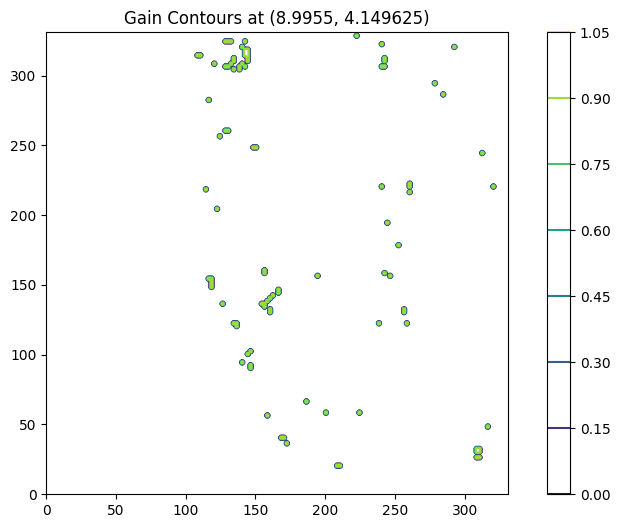

In [66]:
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/examples/8.9955_4.149625/auxiliary/gain.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array[0], cmap = "viridis", 
            )
plt.title("Gain Contours at (8.9955, 4.149625)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

(332, 332)


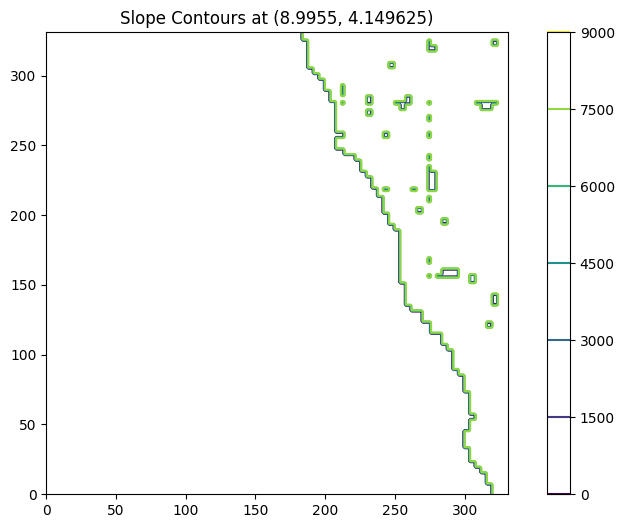

In [67]:
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/examples/8.9955_4.149625/auxiliary/slope.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array, cmap = "viridis", 
            )
plt.title("Slope Contours at (8.9955, 4.149625)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

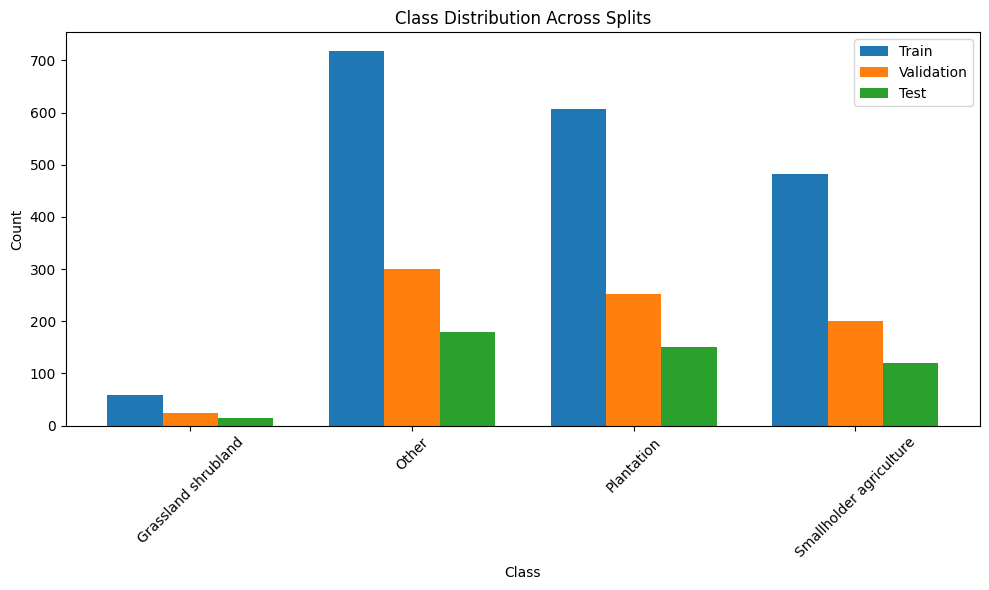

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(train, val, test):
    # Get all unique categories from all datasets
    all_categories = list(set(train['merged_label']) | 
                     set(val['merged_label']) | 
                     set(test['merged_label']))
    all_categories.sort()  # Sort alphabetically
    
    # Create positions for bars
    x = np.arange(len(all_categories))
    width = 0.25
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Function to get counts for each split
    def get_counts(df):
        counts = df['merged_label'].value_counts()
        return [counts.get(cat, 0) for cat in all_categories]
    
    # Plot bars for each split
    plt.bar(x - width, get_counts(train), width, label='Train')
    plt.bar(x, get_counts(val), width, label='Validation')
    plt.bar(x + width, get_counts(test), width, label='Test')
    
    # Add labels and formatting
    plt.xticks(x, all_categories, rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution Across Splits')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with your actual data:
plot_class_distribution(train_df, val_df, test_df)

In [69]:
def load_first_png_image(folder_path):
        png_files = glob.glob(os.path.join(folder_path, '*.png'))

        if not png_files:
            raise FileNotFoundError(f"No PNG files found in {folder_path}")
 
        image = io.imread(png_files[0])
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir='CAM-ForestNetDataset', sub_dir="Landsat-Grouped", transform=None, detailed_labels=False, types="classifier"):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.sub_dir = sub_dir
        self.transform = transform
        if detailed_labels:
            self.label_to_int = {'Oil palm plantation': 0, 'Timber plantation': 1, 'Fruit plantation (e.g. banana)': 2, 'Rubber plantation': 3, 'Other large-scale plantation (e.g. tea, sugarcane)': 4, 'Grassland/Shrubland': 5, 'Small-scale oil palm plantation': 6, 'Small-scale maize plantation': 7, 'Other small-scale agriculture': 8, 'Mining': 9, 'Selective logging': 10, 'Infrastructure': 11, 'Wildfire': 12, 'Hunting': 13, 'Other': 14}
        else:
            self.label_to_int = {'Grassland shrubland':0, 'Other':1, 'Plantation':2, 'Smallholder agriculture':3}
        
        self.types = types

    def __len__(self):
        return len(self.csv)
    
    def poly_from_utm(self, polygon):
        poly_pts = []
        print(polygon.bounds)

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]
        
        image = load_first_png_image(f'{self.root_dir}/{self.sub_dir}/{folder}/images/visible')
        slope = np.load(f'{self.root_dir}/{self.sub_dir}/{folder}/auxiliary/slope.npy')
          
        with open(f'{self.root_dir}/{self.sub_dir}/{folder}/forest_loss_region.pkl', 'rb') as f:
            data = pickle.load(f)
      
        utm_zone = int((long + 180) / 6) + 1
        hemisphere = '6' if lat >= 0 else '7'  # 326 for north, 327 for south
        epsg_code = int(f"32{hemisphere}{utm_zone:02d}")
        project = Transformer.from_crs("epsg:4326", f"epsg:{epsg_code}", always_xy=True).transform

        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'MultiPolygon':
            data = list(data)

        projected_polys = [shapely_transform(project, poly) for poly in data]

        utm_x, utm_y = project(long, lat)

        half = (332 * PIXEL_RESOLUTION) / 2
        transform = from_origin(utm_x - half, utm_y + half, PIXEL_RESOLUTION, PIXEL_RESOLUTION)

        mask = rasterize(
            [(poly, 1) for poly in projected_polys],
            out_shape=(332, 332),
            transform=transform,
            fill=0,
            dtype='uint8'
        )

        seg = np.array(mask)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
          
        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, seg, slope, merged_label
        else:
            return image, seg, merged_label
 

In [70]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03
        ),
    ]
)

In [71]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [72]:

train_dataset = ForestDataset( csv_file_to_df=train_df, transform=transform, root_dir=BASE_DIR, sub_dir=SUB_DIR)
val_dataset = ForestDataset( csv_file_to_df=val_df, root_dir=BASE_DIR, sub_dir=SUB_DIR)
test_dataset = ForestDataset( csv_file_to_df=test_df, root_dir=BASE_DIR, sub_dir=SUB_DIR)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

images shape on PyTorch :  torch.Size([16, 3, 160, 160])
seg shape on PyTorch :  torch.Size([16, 160, 160])
slope shape on PyTorch :  torch.Size([16, 160, 160])
labels shape on Pytorch :  torch.Size([16])


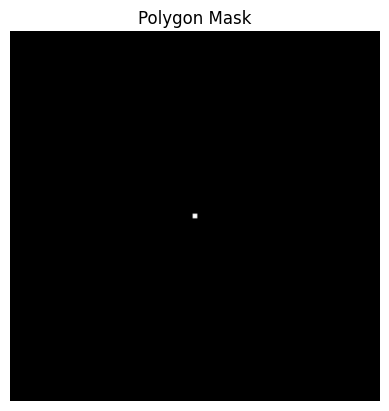

In [74]:
dataiter = iter(trainloader)
images, seg, slope, labels = next(dataiter)

print('images shape on PyTorch : ', images.size())
print('seg shape on PyTorch : ', seg.size())
print('slope shape on PyTorch : ', slope.size())
print('labels shape on Pytorch : ', labels.size())

plt.imshow(seg[0].numpy(), cmap='gray')
plt.title("Polygon Mask")
plt.axis('off')
plt.show()

In [75]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 160, 160])
torch.Size([16, 160, 160])


In [76]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [77]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

## Multimodal SuperCon using UNet

In [60]:
def train_model_SCL(model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    start = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler('cpu')

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train','val']:
            if(phase == 'train'):
                model.train() 
            else:
                model.eval()
            
            running_loss = 0.0
            
            for inputs,seg,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                seg=seg.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / 4
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    if phase == 'train' and (step + 1) % 4 == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        optimizer.zero_grad()

                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            if phase=='val' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    end = time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
"""Training Projection Head"""

unet_down_model = UNet(3,1,"projection")
unet_down_model = unet_down_model.to(device)

criterion = SupervisedContrastiveLoss()
optimizer = torch.optim.Adam(unet_down_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model_SCL(unet_down_model, criterion, optimizer, scheduler, 20, dataloaders_re)

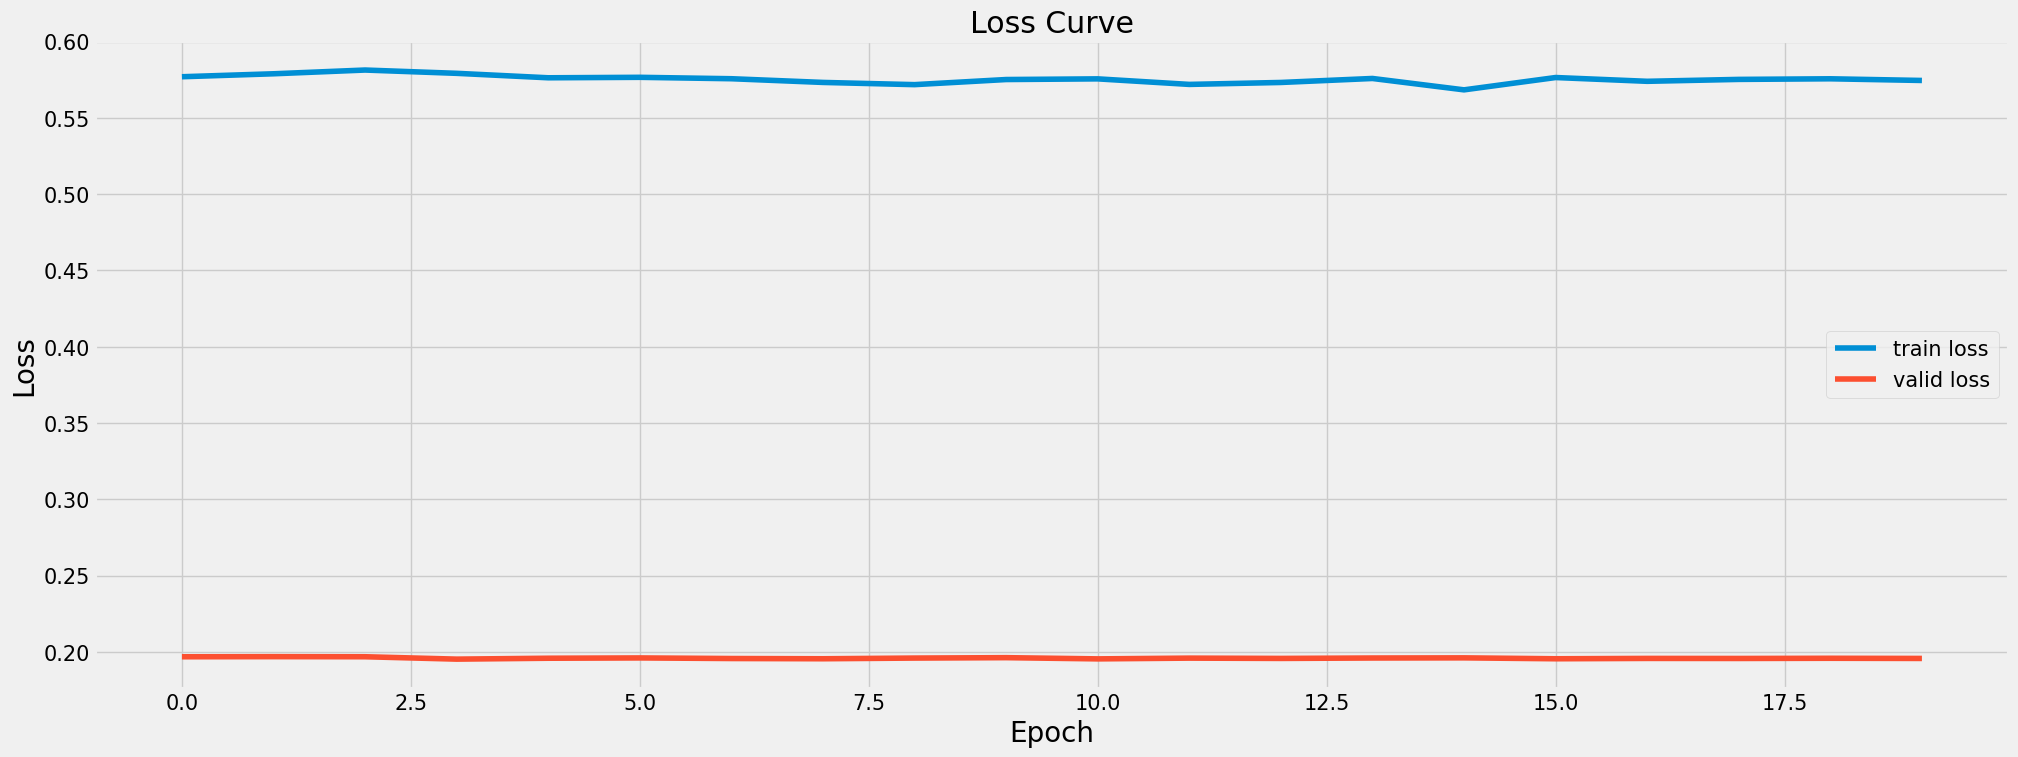

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(22,8))
epochs = list(range(20))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['val loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve')

In [78]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

In [79]:
"""Training UNet Classifier + Segmentation"""

unet_model = UNet(3,1,"classification")
unet_model = unet_model.to(device)

optimizer = torch.optim.AdamW(unet_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_seg_dict = {'train':[], 'val':[]}
acc_class_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

In [84]:
def train_model(model, optimizer, scheduler, dataloaders, criterion_seg, criterion_class,
                acc_seg_dict, acc_class_dict, loss_dict, device,
                num_epochs=25, patience=5,save_dir='model_weights', resume=False):
    
    os.makedirs(save_dir, exist_ok=True)

    def get_dynamic_filename(epoch=None, acc=None, suffix="pth"):
        date_str = datetime.now().strftime("%Y%m%d")
        name_parts = [str(x) for x in [MODEL_NAME, SUB_DIR]]
        if epoch is not None:
            name_parts.append(f"epoch{epoch}")
        if acc is not None:
            name_parts.append(f"acc{acc:.4f}")
        name_parts.append(date_str)
        return os.path.join(save_dir, "_".join(name_parts) + f".{suffix}")

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0
    start_epoch = 0

    checkpoint_path = get_dynamic_filename(suffix="checkpoint")

    # Resume if enabled
    if resume and os.path.exists(checkpoint_path):
        checkpoint = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        best_acc = checkpoint['best_acc']
        start_epoch = checkpoint['epoch'] + 1
        epochs_without_improvement = checkpoint.get('epochs_without_improvement', 0)
        best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(start_epoch, num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_acc_seg = 0.0
            running_acc_class = 0.0

            for images, seg, slope, labels in dataloaders[phase]:
                images, seg, slope, labels = images.to(device), seg.to(device), slope.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, out_class = model(images, slope)
                    loss_seg = criterion_seg(outputs, torch.unsqueeze(seg.float(), dim=1))
                    loss_class = criterion_class(out_class, labels)
                    loss = loss_seg + loss_class

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                m1, m0, m_avg = get_acc_binseg(outputs, torch.unsqueeze(seg.float(), dim=1))
                running_acc_seg += m_avg
                running_acc_class += get_acc_class(out_class, labels).item()
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc_seg = running_acc_seg / len(dataloaders[phase])
            epoch_acc_class = running_acc_class / len(dataloaders[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc Seg: {epoch_acc_seg:.4f} Acc Class: {epoch_acc_class:.4f}')
            acc_seg_dict[phase].append(epoch_acc_seg)
            acc_class_dict[phase].append(epoch_acc_class)
            loss_dict[phase].append(epoch_loss)

            # Save checkpoint if best
            if phase == 'val':
                if epoch_acc_class > best_acc:
                    best_acc = epoch_acc_class
                    best_model_wts = copy.deepcopy(model.state_dict())
                    save_checkpoint({
                        'epoch': epoch,
                        'model_state_dict': best_model_wts,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_acc': best_acc,
                        'epochs_without_improvement': 0,
                    }, checkpoint_path)
                    epochs_without_improvement = 0
                    print(f"New best model saved at epoch {epoch+1}")
                else:
                    epochs_without_improvement += 1
                    print(f"No improvement. Patience counter: {epochs_without_improvement}/{patience}")

                if epochs_without_improvement >= patience:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_model_wts)
                    final_path = get_dynamic_filename(epoch=epoch, acc=best_acc)
                    torch.save(model.state_dict(), final_path)
                    print(f"Final model saved to {final_path}")
                    return model

    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    final_path = get_dynamic_filename(epoch=num_epochs, acc=best_acc)
    torch.save(model.state_dict(), final_path)
    print(f"Final model saved to {final_path}")
    return model

In [96]:
unet_classifier_segmentation = train_model(
    unet_model,
    optimizer,
    scheduler,
    num_epochs=15,
    dataloaders=dataloaders,
    criterion_seg=criterion_seg,
    criterion_class=criterion_class,
    acc_class_dict=acc_class_dict,
    acc_seg_dict=acc_seg_dict,
    loss_dict=loss_dict,
    device="cpu"
)


Epoch 1/15
----------
train Loss: 1.3089 Acc Seg: 0.5285 Acc Class: 0.5673
val Loss: 1.4876 Acc Seg: 0.5515 Acc Class: 0.4360
Checkpoint saved to model_weights/UNet_Landsat-Grouped_20250611.checkpoint
New best model saved at epoch 1

Epoch 2/15
----------
train Loss: 1.1643 Acc Seg: 0.5511 Acc Class: 0.6971
val Loss: 1.4630 Acc Seg: 0.5799 Acc Class: 0.4487
Checkpoint saved to model_weights/UNet_Landsat-Grouped_20250611.checkpoint
New best model saved at epoch 2

Epoch 3/15
----------
train Loss: 1.0957 Acc Seg: 0.5542 Acc Class: 0.7799
val Loss: 1.7927 Acc Seg: 0.5724 Acc Class: 0.3888
No improvement. Patience counter: 1/5

Epoch 4/15
----------
train Loss: 1.0797 Acc Seg: 0.5681 Acc Class: 0.7788
val Loss: 1.6964 Acc Seg: 0.4742 Acc Class: 0.4477
No improvement. Patience counter: 2/5

Epoch 5/15
----------
train Loss: 1.0717 Acc Seg: 0.5475 Acc Class: 0.7991
val Loss: 1.8617 Acc Seg: 0.5506 Acc Class: 0.4597
Checkpoint saved to model_weights/UNet_Landsat-Grouped_20250611.checkpoint


In [99]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

<Figure size 2200x800 with 0 Axes>

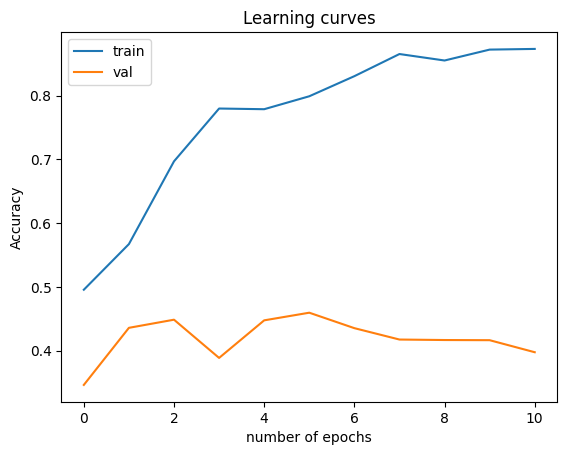

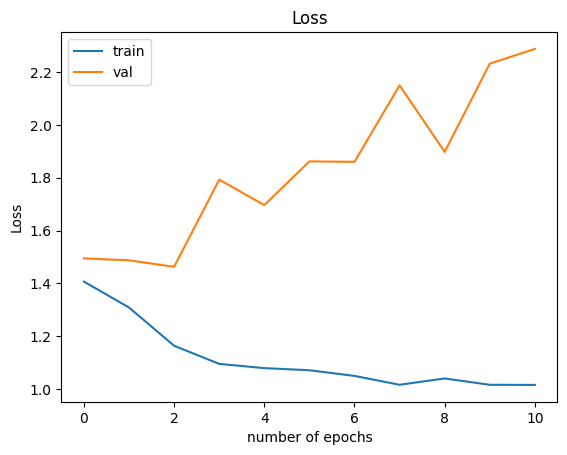

In [100]:
show_curves(acc_class_dict, loss_dict)

<Figure size 2200x800 with 0 Axes>

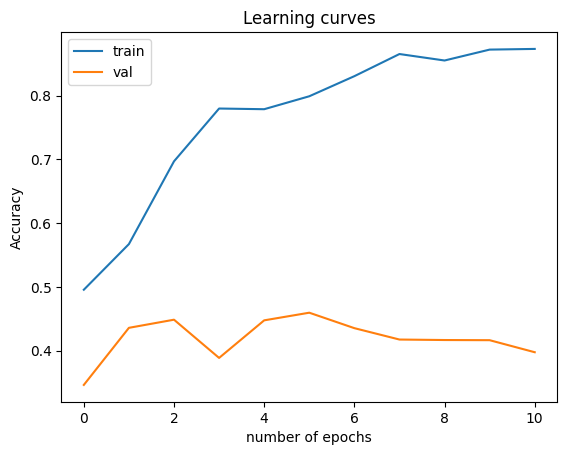

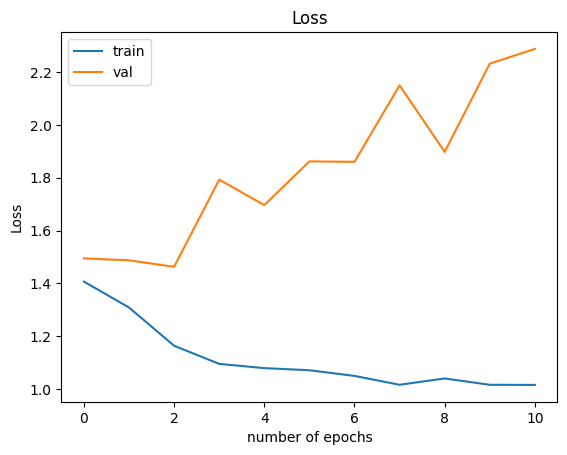

In [101]:
show_curves(acc_class_dict, loss_dict)

In [107]:
def test(model, dataloader, dataset):
    model.eval()

    all_preds = []
    all_labels = []
    class_names = [label for label, _ in sorted(dataset.label_to_int.items(), key=lambda x: x[1])]

    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, seg, slope, labels in dataloader: 
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            labels = labels.to(device)

            outputs, out_class = model(images, slope)

            total += labels.size(0) 
            running_accuracy += get_acc_class(out_class, labels).item()
            preds = torch.argmax(out_class, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy()) 
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / len(testloader))) 

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
 

In [108]:
test(unet_classifier_segmentation, testloader, test_dataset)

Accuracy of the model based on the test set is: 46 %

Classification Report:
                         precision    recall  f1-score   support

    Grassland shrubland       0.33      0.07      0.11        15
                  Other       0.42      0.73      0.53       180
             Plantation       0.49      0.26      0.34       151
Smallholder agriculture       0.66      0.38      0.48       120

               accuracy                           0.47       466
              macro avg       0.48      0.36      0.37       466
           weighted avg       0.50      0.47      0.45       466


Confusion Matrix:
[[  1  14   0   0]
 [  0 131  32  17]
 [  1 103  40   7]
 [  1  64   9  46]]


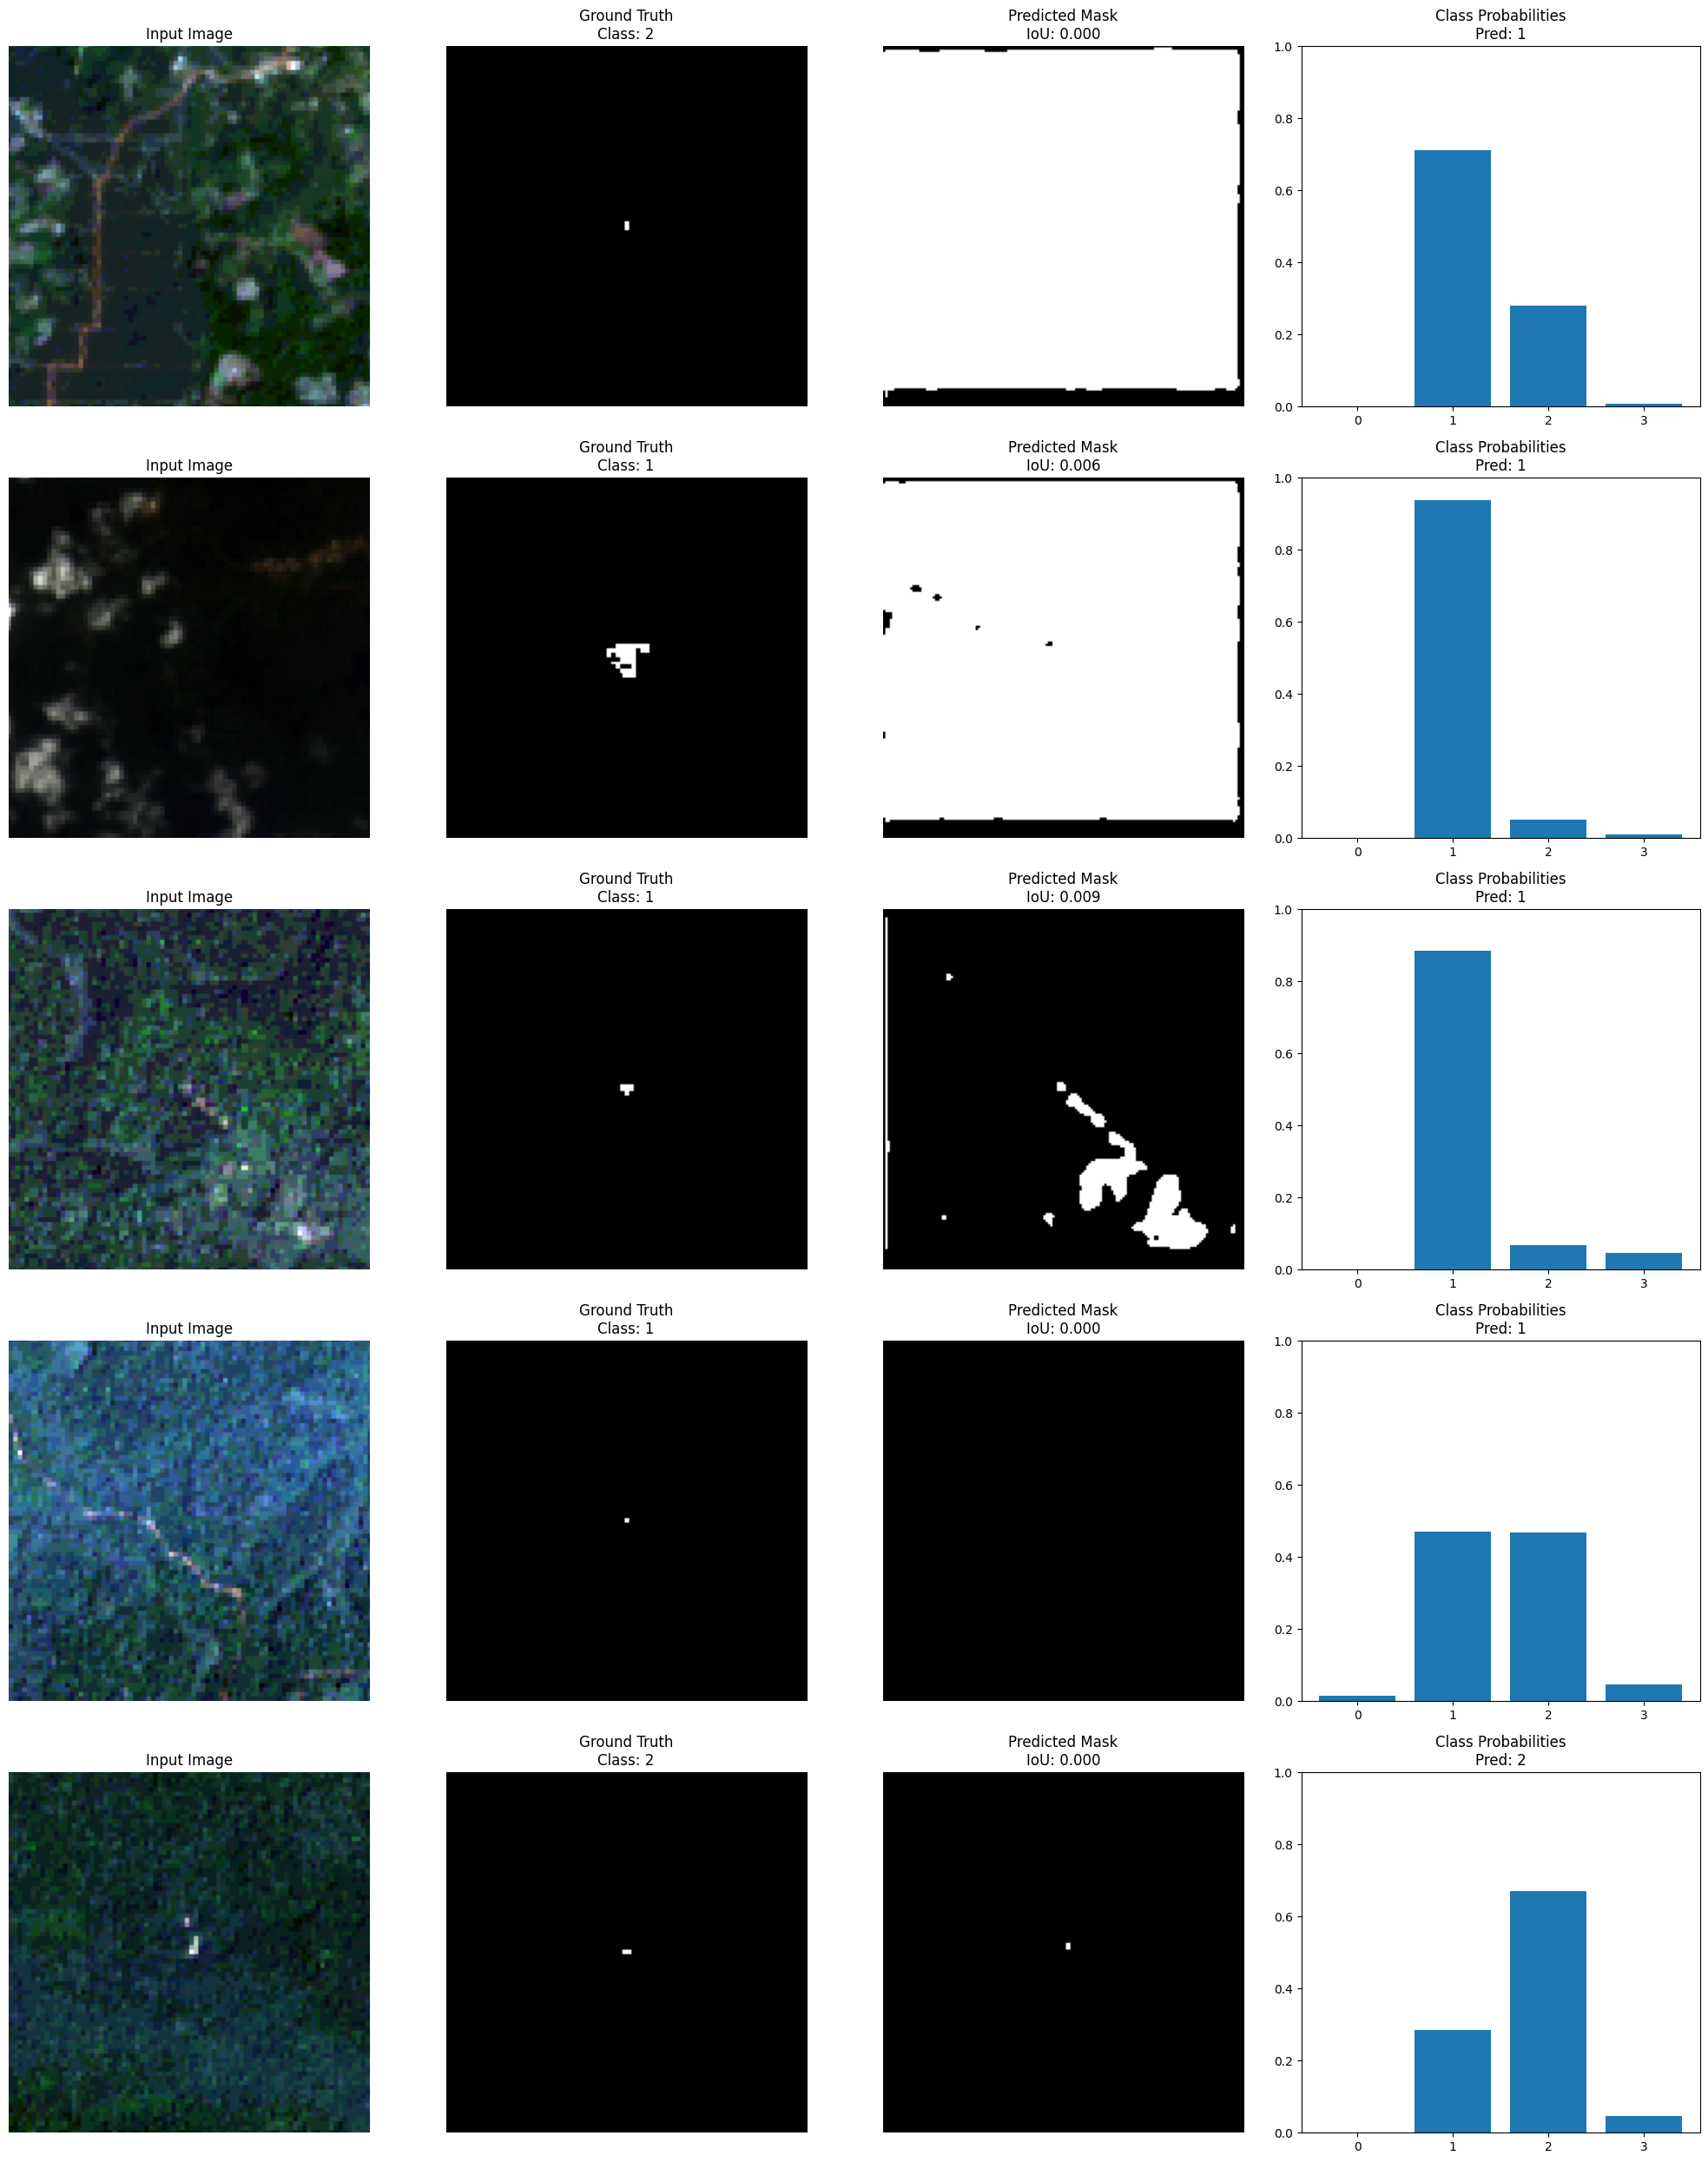

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_prediction_comparison(model, dataloader, num_examples=3):
    model.eval()
    fig, axes = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))
    
    with torch.no_grad():
        for i, (images, seg, slope, labels) in enumerate(dataloader):
            if i >= num_examples:
                break
                
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            
            outputs, out_class = model(images, slope)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            pred_class = torch.argmax(out_class, dim=1)
            
            img_np = images[0].cpu().permute(1,2,0).numpy()
            img_np = img_np.astype(np.float32)
            for c in range(3):
                channel = img_np[:, :, c]
                img_np[:, :, c] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-5)

            true_mask = seg[0].cpu().numpy().flatten()
            pred_mask = pred_masks[0, 0].cpu().numpy().flatten()
            
            iou = jaccard_score(true_mask, pred_mask, average='binary')
            
            axes[i,0].imshow(img_np)
            axes[i,0].set_title('Input Image')
            axes[i,0].axis('off')
            
            axes[i,1].imshow(true_mask.reshape(seg.shape[1], seg.shape[2]), cmap='gray')
            axes[i,1].set_title(f'Ground Truth\nClass: {labels[0].item()}')
            axes[i,1].axis('off')
            
            axes[i,2].imshow(pred_mask.reshape(seg.shape[1], seg.shape[2]), cmap='gray')
            axes[i,2].set_title(f'Predicted Mask\nIoU: {iou:.3f}')
            axes[i,2].axis('off')
            
            class_probs = torch.softmax(out_class[0], dim=0).cpu().numpy()
            num_classes = class_probs.shape[0]
            axes[i,3].bar([str(i) for i in range(num_classes)], class_probs)
            pred_class = torch.argmax(out_class[0]).item()
            axes[i,3].set_title(f'Class Probabilities\nPred: {pred_class}')
            axes[i,3].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()


plot_prediction_comparison(unet_classifier_segmentation, testloader, num_examples=5)